In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast, Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoModelForCausalLM, AutoTokenizer
import torch
import re ,os
import pandas as pd
import re

In [ ]:
# 로딩 예시
exaone_save_dir = '/content/drive/MyDrive/models/exaone_1'
exaone_model = AutoModelForCausalLM.from_pretrained(exaone_save_dir,trust_remote_code=True,device_map='auto')
exaone_tokenizer = AutoTokenizer.from_pretrained(exaone_save_dir,trust_remote_code=True)

In [108]:
test_data_kobart = pd.read_csv('/content/drive/MyDrive/생성데이터/test_exa.csv')
test_data_exaone = pd.read_csv('/content/drive/MyDrive/생성데이터/test_exa.csv')

In [5]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 경로 설정
kobart_model_path = '/content/drive/MyDrive/models/kobart_finetuning(GS_100epoch)'

# 토크나이저 및 모델 불러오기
kobart_tokenizer = PreTrainedTokenizerFast.from_pretrained(kobart_model_path)
kobart_model = BartForConditionalGeneration.from_pretrained(kobart_model_path,device_map='auto')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
import pandas as pd
import torch
import re
from datasets import Dataset
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# 1. CSV 파일을 Pandas DataFrame으로 읽기
csv_file_path = '/content/drive/MyDrive/생성데이터/test_exa.csv'  # CSV 파일 경로를 맞춰주세요
test_data_kobart = pd.read_csv(csv_file_path)

# 2. DataFrame을 Hugging Face Dataset으로 변환
test_data_kobart_dataset = Dataset.from_pandas(test_data_kobart, preserve_index=False)

# 3. 모델과 토크나이저 경로 설정
kobart_model_path = '/content/drive/MyDrive/models/kobart_finetuning(GS_100epoch)'  # 모델 경로
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델과 토크나이저 불러오기
kobart_tokenizer = PreTrainedTokenizerFast.from_pretrained(kobart_model_path)
kobart_model = BartForConditionalGeneration.from_pretrained(kobart_model_path).to(device)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [119]:
# # 4. 특수 문자 제거 함수
# def kobart_remove_special_chars(text):
#     match = re.search(r'[^\x00-\x7F]', text)
#     if match:
#         text = text[:match.start()]
#     return text.strip()

# 5. 요약 생성 함수
def generate_summary(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True, padding=True)

    # 입력 데이터를 모델과 동일한 디바이스로 이동
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # 요약 생성
    output = model.generate(
        inputs['input_ids'],
        max_length=300,
        num_beams=5,
        length_penalty=1.5,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    decoded_summary = tokenizer.decode(output[0], skip_special_tokens=True)
    # cleaned_summary = kobart_remove_special_chars(decoded_summary)

    return decoded_summary

# 6. 전처리 함수 정의
def preprocess_function(examples):
    model_inputs = kobart_tokenizer(examples["input"], max_length=1024, truncation=True, padding="max_length")
    labels = kobart_tokenizer(examples["summary"], max_length=256, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 7. 데이터셋 전처리 적용
tokenized_test_dataset = test_data_kobart_dataset.map(preprocess_function, batched=True)

# 8. 예측 수행
predicted_summaries = []

for i in range(len(tokenized_test_dataset)):
    # 원본 텍스트 가져오기
    original_text = kobart_tokenizer.decode(tokenized_test_dataset[i]['input_ids'], skip_special_tokens=True)

    # 예측 수행
    predicted_summary = generate_summary(kobart_model, kobart_tokenizer, original_text)

    # 결과 저장
    predicted_summaries.append(predicted_summary)

    print(f"원본 텍스트: {original_text}")
    print(f"예측된 요약: {predicted_summary}")
    print("="*50)

# 9. 결과 DataFrame으로 저장
test_data_kobart['result'] = predicted_summaries
test_data_kobart.to_csv('test_data_kobart_result.csv', index=False, encoding='utf-8-sig')  # 결과를 CSV로 저장

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Model is on: cuda:0


Map:   0%|          | 0/31 [00:00<?, ? examples/s]

원본 텍스트: 제1조 [목적] 이 계약서의 작성 목적은 갑과 을 간 상품의 직매입거래(갑이 매입 한 상품 중 판매되지 아니한 상품에 대한 판매책임을 부담하고 을로부터 상 품을 매입하는 형태의 거래를 말한다)에서 양 당사자 사이의 기본적인 권리와  의무를 정하기 위함에 있다.
예측된 요약: 제1조조 [목적] 이 계약서의 목적은 갑과 을 간 상품 직매입거래에 대한 기본적인 권리와 의무를 설정하기 위함이다. 계약 목적은 판매되지 않은 상품에 대해 갑이 책임책임을 부담하고 을로부터 상품을 매입하는 형태이기 때문에 갑은 상품의 판매율과 의무를 정하기 위해 계약서를 작성해야 함을 규정한다
ィ㞳㗡づἹîヴ㵓ァ
원본 텍스트: 제2조 [기본원칙] 1 갑과 을은 상호이익을 존중하고 이 계약상 의무를 신의에 따라 성실 히 이행함으로써 상호 공정한 거래관계와 동반성장을 추구한다.  2 갑과 을은 이 계약의 이행과 관련하여 「대규모유통업에서의 거래  공정화에 관한 법률」 및 그 시행령 등 관련 법령의 규정을 준수한다.  3 을이 수입 명품 브랜드를 보유하는 등 갑이 을에 대하여 거래상  우월적 지위에 있다고 인정되지 아니할 경우에는 이 표준거래계약서의 내용을  거래 현실에 맞게 수정하여 사용할 수 있다.
예측된 요약: 갑과 을은 상호이익을 존중하고 계약상 의무를 성실히 이행하며 공정거래법을 준수하고 관련 법령을 준수해야 한다 을이 수입 명품 브랜드 등을 보유하여 갑이 을에 대해 우월적 지위에 없을 경우 계약 내용을 조정할 수 있으며 계약 이행 시 관련 법률을 준수한다는 것을 규정한다고 전했다.
㞳㗡ィἹîづ䃤㵓ヴ纛ァォ
원본 텍스트: 제3조 [공정거래 준수 및 동반성장 지원] 1 갑과 을은 공정하고 투명한 거래를 위하여 다음 각 호의 내용을 준 수한다.   1. 상대방에게 금품, 향응, 편의 또는 접대를 요구하거나 제공해서는 아니 되며,  위법하거나 부당한 행위를 하지 아니한다.   2. 거래상 우월적 지위를 남용하여 공정한 거래질서에 반하는 행위를 요구하지  아니한다.   2 갑은 을과

In [123]:
def generate_response_exaone(model, tokenizer,sentence):
    prompt = f"""
  원본 문장:{sentence}
원본 문장의 맥락을 살펴보고, 빠르게 문장을 요약하여 재구성합니다.
제목은 그대로 두시고, 내용의 핵심을 추출하여 전체적으로 요약하면 됩니다.
결과는 하나의 문장으로 표현하면 됩니다.
"""

    messages = [
        {"role": "system", "content": "You are an excellent sentence summarizer. You understand the context and concisely summarize key sentences as an assistant."},
        {"role": "user", "content": prompt}
    ]

    # 모델과 tokenizer가 있는 디바이스 설정 (cuda가 가능하면 cuda 사용)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    accelerator = Accelerator()
    model = accelerator.prepare(model)

    # input_ids 생성 및 디바이스로 이동
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # 모델에서 텍스트 생성
    output = model.generate(
        input_ids,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=400,
        do_sample=False
    )

    # 생성된 텍스트 디코딩
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # 프롬프트 길이를 기준으로 생성된 부분만 추출
    generated_text_only = generated_text[len(tokenizer.decode(input_ids[0], skip_special_tokens=True)):]
    summary = generated_text_only.strip()
    summary = re.sub(r"\*\*요약 문장:\*\*:\s*", "", summary)
    summary = re.sub(r"\*\*요약 문장:\*\*:", "", summary)
    summary = re.sub(r"\*\*요약 문장:\*\*", "", summary)
    summary = re.sub(r"\*\*요약:\*\*", "", summary)
    summary = re.sub("\n", "", summary)

    return summary


In [ ]:
torch.cuda.empty_cache()
test_data_exaone['result'] = test_data_exaone['input'].apply(lambda x: generate_response_exaone(exaone_model, exaone_tokenizer, x))

In [ ]:
test_data_exaone.to_csv('test_data_exaone_result.csv', encoding='utf-8-sig', index=False)

In [8]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00


In [9]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f6e471bcc08db29de2cca2c15f8b817b51bf82154a20928773bff8a2de2ec074
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [10]:
import pandas as pd
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
import torch
import re
import evaluate
from accelerate import Accelerator

# ROUGE 계산 함수 (정확도, 재현율, F1 점수)
def compute_rouge(predictions, references):
    rouge = evaluate.load("rouge")
    result = rouge.compute(predictions=predictions, references=references)
    return result

# Perplexity 계산 함수
import torch

def compute_perplexity(model, tokenizer, input_text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    accelerator = Accelerator()
    model = accelerator.prepare(model)

    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items() if key != 'token_type_ids'}  # 'token_type_ids' 제외

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
        logits = outputs.logits

    shift_logits = logits[..., :-1, :].contiguous()  # 마지막 토큰을 제외한 예측 확률
    shift_labels = inputs['input_ids'][..., 1:].contiguous()  # 실제 정답 텍스트, 첫 번째 토큰을 제외

    # CrossEntropyLoss: logits의 크기를 (batch_size * seq_len, vocab_size) 형태로 변환
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    perplexity = torch.exp(loss.mean()).item()
    return perplexity


In [13]:
from rouge_score import rouge_scorer

# ROUGE 계산 함수
def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        rouge_scores["rouge1"].append(score["rouge1"])
        rouge_scores["rouge2"].append(score["rouge2"])
        rouge_scores["rougeL"].append(score["rougeL"])

    return rouge_scores

# 평가 함수
def evaluate_model_on_csv(input_csv_path, model, tokenizer):
    # 1. CSV 파일을 Pandas DataFrame으로 읽기
    test_data = pd.read_csv(input_csv_path)

    # 2. 평가 지표를 저장할 리스트 초기화
    predicted_summaries = []
    predicted_perplexities = []
    rouge1_precision_scores = []
    rouge1_recall_scores = []
    rouge1_fscore_scores = []
    rouge2_precision_scores = []
    rouge2_recall_scores = []
    rouge2_fscore_scores = []
    rougeL_precision_scores = []
    rougeL_recall_scores = []
    rougeL_fscore_scores = []

    actual_summaries = test_data["summary"].tolist()  # 실제 요약

    # 3. 평가 수행
    for i in range(len(test_data)):
        # 원본 텍스트 가져오기
        original_text = test_data["input"].iloc[i]
        # 예측된 요약 생성 (여기서는 이미 예측된 값이 있다고 가정)
        predicted_summary = test_data["result"].iloc[i]  # 예측된 요약이 이미 포함된 경우 사용

        # Perplexity 계산
        perplexity = compute_perplexity(model, tokenizer, original_text)

        # ROUGE 계산
        rouge = compute_rouge([predicted_summary], [test_data["summary"].iloc[i]])

        # ROUGE1, ROUGE2, ROUGEL 지표에서 precision, recall, fscore 값 추출
        rouge1_precision_scores.append(rouge['rouge1'][0].precision)
        rouge1_recall_scores.append(rouge['rouge1'][0].recall)
        rouge1_fscore_scores.append(rouge['rouge1'][0].fmeasure)

        rouge2_precision_scores.append(rouge['rouge2'][0].precision)
        rouge2_recall_scores.append(rouge['rouge2'][0].recall)
        rouge2_fscore_scores.append(rouge['rouge2'][0].fmeasure)

        rougeL_precision_scores.append(rouge['rougeL'][0].precision)
        rougeL_recall_scores.append(rouge['rougeL'][0].recall)
        rougeL_fscore_scores.append(rouge['rougeL'][0].fmeasure)

        # 결과 저장
        predicted_summaries.append(predicted_summary)
        predicted_perplexities.append(perplexity)

    # 4. 결과를 DataFrame으로 저장
    test_data['predicted_perplexity'] = predicted_perplexities

    # ROUGE1, ROUGE2, ROUGEL에 대한 precision, recall, fscore를 DataFrame에 저장
    test_data['rouge1_precision'] = rouge1_precision_scores
    test_data['rouge1_recall'] = rouge1_recall_scores
    test_data['rouge1_fscore'] = rouge1_fscore_scores

    test_data['rouge2_precision'] = rouge2_precision_scores
    test_data['rouge2_recall'] = rouge2_recall_scores
    test_data['rouge2_fscore'] = rouge2_fscore_scores

    test_data['rougeL_precision'] = rougeL_precision_scores
    test_data['rougeL_recall'] = rougeL_recall_scores
    test_data['rougeL_fscore'] = rougeL_fscore_scores

    # 5. CSV 파일로 저장
    output_csv_path = input_csv_path.replace(".csv", "_with_metrics.csv")
    test_data.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
    print(f"Evaluation results saved to {output_csv_path}")

In [14]:
# 평가 수행 함수 호출
exaone_csv_path = '/content/drive/MyDrive/models/test_data_exaone_result.csv'
kobart_csv_path = '/content/drive/MyDrive/models/test_data_kobart_result.csv'
evaluate_model_on_csv(exaone_csv_path, exaone_model, exaone_tokenizer)
evaluate_model_on_csv(kobart_csv_path, kobart_model, kobart_tokenizer)

Evaluation results saved to /content/drive/MyDrive/models/test_data_exaone_result_with_metrics.csv
Evaluation results saved to /content/drive/MyDrive/models/test_data_kobart_result_with_metrics.csv


In [15]:
exaone_result = pd.read_csv('/content/drive/MyDrive/models/test_data_exaone_result_with_metrics.csv')
kobart_result = pd.read_csv('/content/drive/MyDrive/models/test_data_kobart_result_with_metrics.csv')

In [21]:
kobart_result

,input,summary,result,predicted_perplexity,rouge1_precision,rouge1_recall,rouge1_fscore,rouge2_precision,rouge2_recall,rouge2_fscore,rougeL_precision,rougeL_recall,rougeL_fscore
0,제1조 [목적] 이 계약서의 작성 목적은 갑과 을 간 상품의 직매입거래(갑이 매입 ...,제1조 [목적] 이 조는 ‘갑’과 ‘을’이 상품을 직매입거래(‘갑’이 상품을 미리 ...,제1조 [목적] 이 계약서의 목적은 갑과 을 간 상품 직매입거래에 대한 기본적인 권...,6.794934e+05,1.000000,1.000000,1.000000,0.000000,0.00,0.000000,1.000000,1.000000,1.000000
1,제2조 [기본원칙] ① 갑과 을은 상호이익을 존중하고 이 계약상 의무를 신의에 따라...,제2조 [기본원칙] 갑과 을은 상호 이익을 존중하고 신의성실 원칙에 따라 공정한 거...,제2조 [기본원칙] 갑과 을은 상호이익을 존중하고 계약상 의무를 성실히 이행하며 공...,1.673005e+05,1.000000,1.000000,1.000000,0.000000,0.00,0.000000,1.000000,1.000000,1.000000
2,제3조 [공정거래 준수 및 동반성장 지원] ① 갑과 을은 공정하고 투명한 거래를 위...,제3조 [공정거래 준수 및 동반성장 지원] 갑과 을은 금품·향응 제공이나 우월적 지...,제3조 [공정거래 준수 및 동반성장 지원] 공정하고 투명한 거래를 위해 갑과 을은 ...,3.776981e+05,1.000000,1.000000,1.000000,0.000000,0.00,0.000000,1.000000,1.000000,1.000000
3,"제4조 [상품의 납품] ① 을이 갑에게 납품하여야 하는 상품의 종류, 수량 및 가격...",제4조 [상품의 납품] 을은 별지 또는 관련 문서를 통해 정해진 상품 종류·수량·가...,제4조 [상품의 납품] 갑은 갑에게 상품을 납품해야 하며 관련 법령을 준수해야 함을...,3.303672e+05,1.000000,1.000000,1.000000,0.000000,0.00,0.000000,1.000000,1.000000,1.000000
4,제5조 [검수기준 및 품질검사] ① 갑은 납품받는 상품에 관하여 갑의 검수기준에 따...,제5조 [검수기준 및 품질검사] 갑은 사전에 고지한 검수기준에 따라 납품상품을 검사...,제5조 [검수기준 및 품질검사] 갑은 갑의 검수기준에 따라 검수를 하고 필요 시 품...,4.000041e+05,1.000000,1.000000,1.000000,0.000000,0.00,0.000000,1.000000,1.000000,1.000000
5,제6조 [납품대금 지급 및 감액금지] ① 갑은 납품대금을 상품 입고일부터 60일 이...,제6조 [납품대금 지급 및 감액금지] 갑은 상품 입고일부터 60일 이내에 현금성 결...,제6조 [납품대금 지급 및 감액금지] 갑은 납품대금을 상품 입고일부터 60일 이내에...,5.713898e+05,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000
6,제6조의2 [공급원가 변동에 따른 납품 가격의 조정] ①을은 계약 체결 이후 최저임...,제6조의2 [공급원가 변동에 따른 납품 가격의 조정] 을은 최저임금 인상이나 원재료...,제6조의2 [공급원가 변동에 따른 납품 가격의 조정] 을은 계약 체결 후 원재료 가...,5.937396e+05,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000
7,제7조 [상품의 반품] ① 갑은 정당한 사유 없이 을로부터 매입한 상품의 전부 또는...,제7조 [상품의 반품] 갑은 원칙적으로 정당한 사유 없이 매입 상품을 반품할 수 없...,제7조 [상품의 반품] 갑은 정당한 사유 없이 상품을 반품할 수 없으며 하자나 오손...,2.901255e+05,0.500000,1.000000,0.666667,0.000000,0.00,0.000000,0.500000,1.000000,0.666667
8,제8조 [판매장려금] ① 갑은 상품의 판매촉진을 위하여 다음 조건에 따라 을로부터 ...,제8조 [판매장려금] 갑은 사전에 정해진 목적·시기·횟수·인센티브율에 따라 성과장려...,제8조 [판매장려금] 갑은 상품의 판매 촉진을 위해 일정량 이상의 상품을 판매할 수...,1.122672e+05,0.333333,1.000000,0.500000,0.000000,0.00,0.000000,0.333333,1.000000,0.500000
9,제9조 [판촉사원 파견 등] ① 갑은 을로부터 을의 종업원이나 을이 고용한 인력(이...,제9조 [판촉사원 파견 등] 갑은 원칙적으로 을에게 판촉사원 파견이나 인건비 부담을...,제9조 [판촉사원 파견 등] 갑은 을로부터 판촉사원을 파견받아 판매 및 관리 업무를...,3.171271e+05,0.250000,0.500000,0.333333,0.000000,0.00,0.000000,0.250000,0.500000,0.333333


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
columns_to_compare = [
    'predicted_perplexity', 'rouge1_precision', 'rouge1_recall', 'rouge1_fscore',
    'rouge2_precision', 'rouge2_recall', 'rouge2_fscore', 'rougeL_precision',
    'rougeL_recall', 'rougeL_fscore'
]

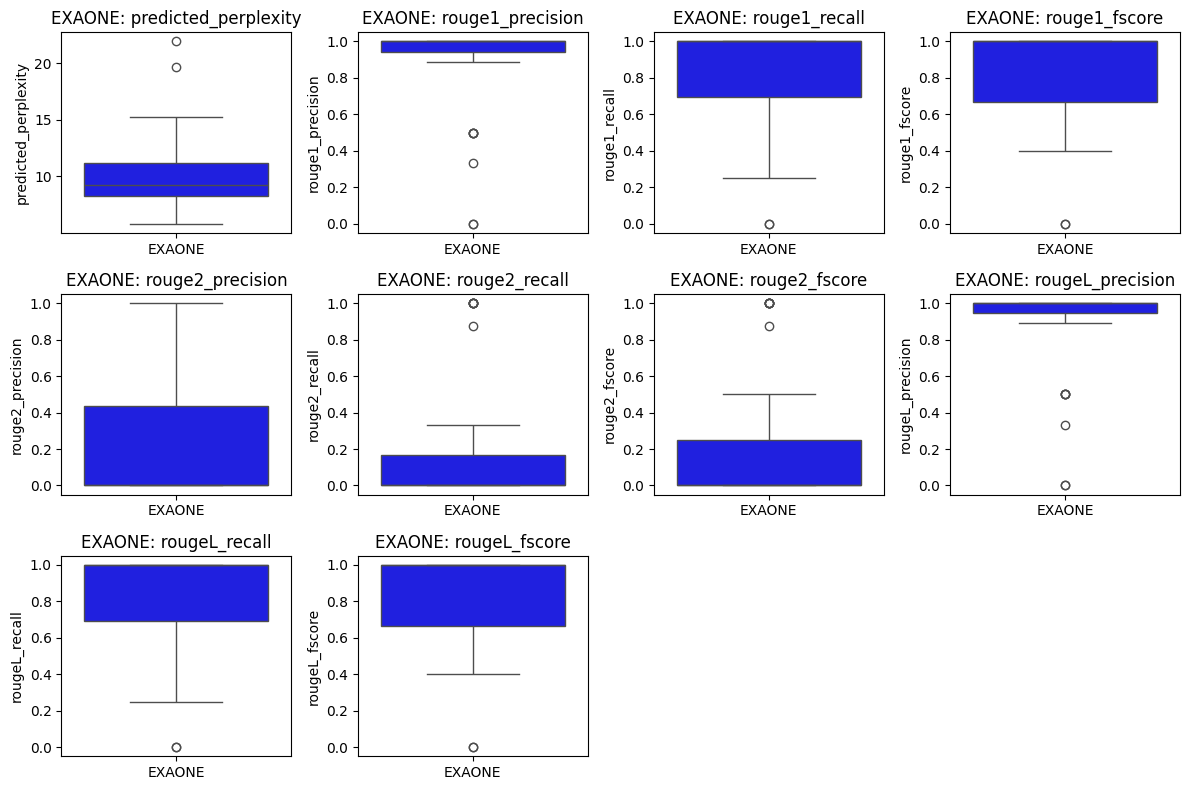

In [18]:
# EXAONE 데이터프레임에 대해 박스 플롯 그리기
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_compare, 1):
    plt.subplot(3, 4, i)  # 3행 4열에 배치
    sns.boxplot(data=exaone_result[col], color='blue')
    plt.title(f'EXAONE: {col}')
    plt.xticks([0], ['EXAONE'])

plt.tight_layout()
plt.show()


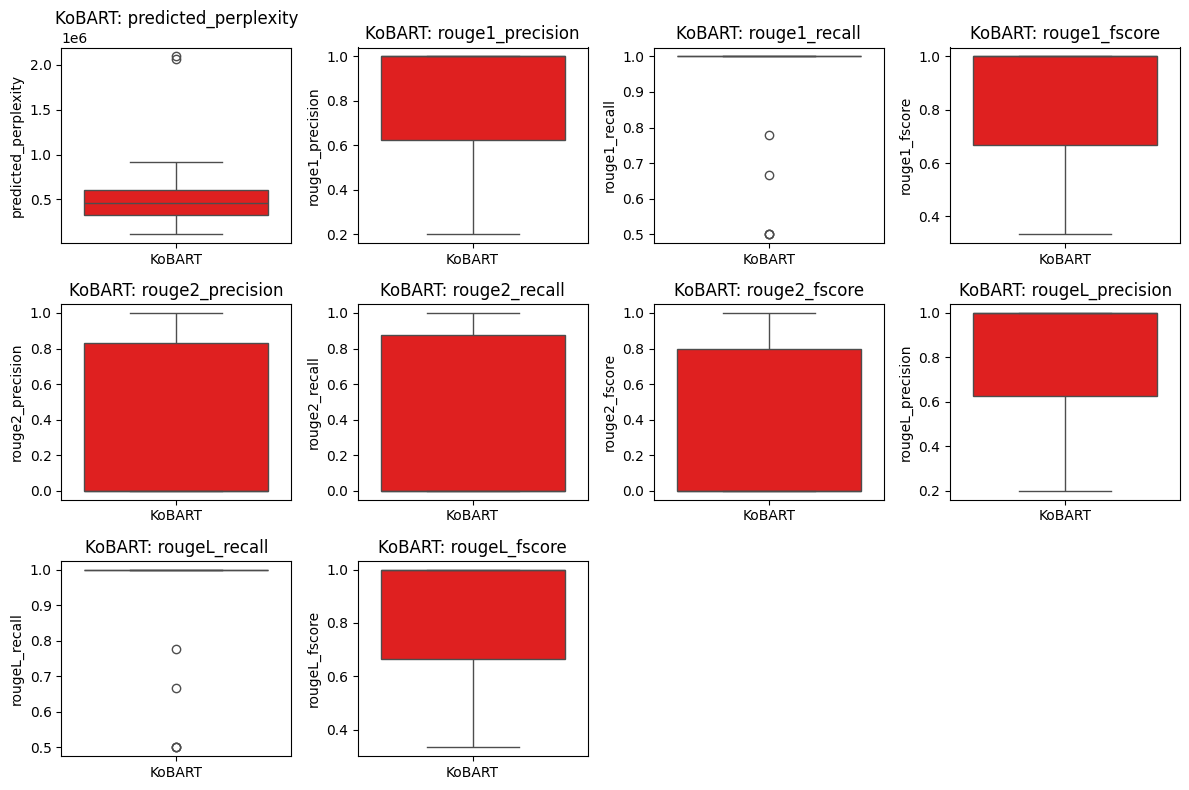

In [19]:
# KoBART 데이터프레임에 대해 박스 플롯 그리기
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_compare, 1):
    plt.subplot(3, 4, i)  # 3행 4열에 배치
    sns.boxplot(data=kobart_result[col], color='red')
    plt.title(f'KoBART: {col}')
    plt.xticks([0], ['KoBART'])

plt.tight_layout()
plt.show()
# perplexity 폭발 원인은 ィ㞳㗡づἹî䃤ヴ㵓ネ 이런 문자 때문# perplexity 폭발 원인은 ィ㞳㗡づἹî䃤ヴ㵓ネ 이런 문자 때문
# 대부분 이상 삽입 문자는 문장 끝에서 이루어지기 때문에, rouge지표에는 영향이 적다.